In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from PIL import Image

In [2]:
from __future__ import division
%matplotlib inline

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Style Transfer

In [4]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    print(f'image.size = ', image.size)
    if transform:
        image = transform(image).unsqueeze(0)  # 在开头插入1维
    print(f'image.shape = ', image.shape)
    return image.to(device)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# 注意图像的像素是要颠倒的, 查看Tensor的维度用.shape, 查看图像维度用.size

In [7]:
content = load_image(image_path='./content.png', transform=transform, max_size=600)
style = load_image(image_path='./style2.png', transform=transform, shape=[content.size(2), content.size(3)])

image.size =  (1080, 623)
image.shape =  torch.Size([1, 3, 623, 1080])
image.size =  (623, 1080)
image.shape =  torch.Size([1, 3, 1080, 623])


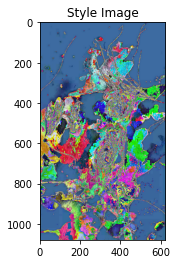

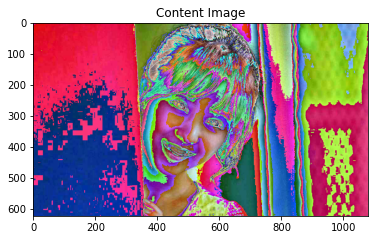

In [8]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

plt.figure()
imshow(style[0], title='Style Image')
imshow(content[0], title='Content Image')

In [9]:
# 特征提取器

In [10]:
class VGGNet(nn.Module):
    def __init__(self):  # __init__()只是存储需要保存的变量，并不是所有的都需要的写进__init__()
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
    
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [11]:
target = content.clone().requires_grad_(True)  # 说明target自身的像素参数需要更新
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

In [12]:
features = vgg(content)  # 每一层拿到的feature vector
for feat in features:
    print(feat.shape)

torch.Size([1, 64, 623, 1080])
torch.Size([1, 128, 311, 540])
torch.Size([1, 256, 155, 270])
torch.Size([1, 512, 77, 135])
torch.Size([1, 512, 38, 67])


In [13]:
target_features = vgg(target)

In [14]:
num_steps = 2000
for step in range(num_steps):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    content_loss = style_loss = 0.
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        content_loss += torch.mean((f1 - f2) ** 2)  # 内容损失
        _, c, h, w = f1.size()
        f1 = f1.view(c, h * w)  # c, h * w
        f3 = f3.view(c, h * w)
        f1 = torch.mm(f1, f1.t())  # c, c
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1 - f3) ** 2) / (c * h * w)  # 风格损失
    loss = content_loss + style_loss * 100.  # 总loss = 权重1 * 内容损失 + 权重2 * 风格损失
    optimizer.zero_grad()  # 更新权重
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f'Step [{step} / {num_steps}], Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}')

Step [0 / 2000], Content Loss: 0.0, Style Loss: 373.2046813964844
Step [100 / 2000], Content Loss: 9.261914253234863, Style Loss: 105.04139709472656
Step [200 / 2000], Content Loss: 10.147754669189453, Style Loss: 65.31620788574219
Step [300 / 2000], Content Loss: 10.577938079833984, Style Loss: 45.91805648803711
Step [400 / 2000], Content Loss: 10.82974910736084, Style Loss: 34.24031448364258
Step [500 / 2000], Content Loss: 11.006352424621582, Style Loss: 26.41503143310547
Step [600 / 2000], Content Loss: 11.143341064453125, Style Loss: 20.797771453857422
Step [700 / 2000], Content Loss: 11.244165420532227, Style Loss: 16.57321548461914
Step [800 / 2000], Content Loss: 11.324662208557129, Style Loss: 13.299452781677246
Step [900 / 2000], Content Loss: 11.388729095458984, Style Loss: 10.729233741760254
Step [1000 / 2000], Content Loss: 11.447694778442383, Style Loss: 8.68154239654541
Step [1100 / 2000], Content Loss: 11.513129234313965, Style Loss: 7.053024768829346
Step [1200 / 2000]

In [32]:
cpu_device = torch.device('cpu')

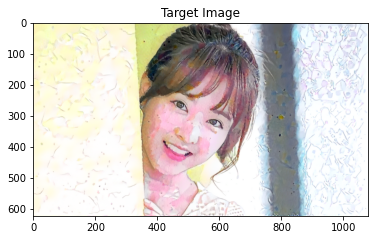

In [36]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze().to(cpu_device)
img = denorm(img).clamp_(0, 1)  #把小于0，变成0，大于1，变成1
img = img.to(device)
plt.figure()
imshow(img, title='Target Image')

# Generative Adversarial Networks

In [14]:
batch_size = 32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_data = torchvision.datasets.MNIST("./mnist_data",
                                        train=True,
                                        download=True,
                                        transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=batch_size,
                                         shuffle=True)

In [5]:
image_size = 784
hidden_size = 256
latent_size = 64

In [6]:
# Discriminator

In [7]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [8]:
# Generator

In [9]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [10]:
D = D.to(device)
G = G.to(device)

In [11]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [12]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [13]:
total_step = len(dataloader)
num_epochs = 500
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.reshape(batch_size, image_size).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.ones(batch_size, 1).to(device)
        outputs = D(images)
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs
        # 开始生成fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())  # detach就是截断反向传播的梯度流
        d_loss_fake = loss_fn(outputs, fake_labels)
        fake_score = outputs
        # 开始优化discriminator
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        # 开始优化generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = loss_fn(outputs, real_labels)
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 1000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.3f}, g_loss: {:.3f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(epoch, num_epochs, i, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], Step [0/1875], d_loss: 1.348, g_loss: 0.679, D(x): 0.51, D(G(z)): 0.51
Epoch [0/500], Step [1000/1875], d_loss: 0.000, g_loss: 0.000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/500], Step [0/1875], d_loss: 0.000, g_loss: 0.000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/500], Step [1000/1875], d_loss: 0.000, g_loss: 0.000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/500], Step [0/1875], d_loss: 0.000, g_loss: 0.000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/500], Step [1000/1875], d_loss: 0.000, g_loss: 0.000, D(x): 1.00, D(G(z)): 1.00
Epoch [3/500], Step [0/1875], d_loss: 0.000, g_loss: 0.000, D(x): 1.00, D(G(z)): 1.00


KeyboardInterrupt: 